In [38]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                            confusion_matrix, roc_auc_score, roc_curve)
import shap

In [40]:
# 2. Load Data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [41]:
# 3. Read Uploaded File
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingM

In [46]:
# 4. Data Cleaning
initial_len = len(df)
df = df[df['TotalCharges'] != ' ']
df['TotalCharges'] = df['TotalCharges'].astype(float)
print(f"Removed {initial_len - len(df)} rows with invalid TotalCharges")

Removed 0 rows with invalid TotalCharges


In [48]:
# 5. Preprocessing
# Clean column names first
df.columns = df.columns.str.strip()

# Drop customerID if present
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)
else:
    print("Warning: 'customerID' column not found")

# Label Encoding
for col in df.select_dtypes(include='object').columns:
    if col != 'Churn':
        df[col] = LabelEncoder().fit_transform(df[col])

# Target Variable
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

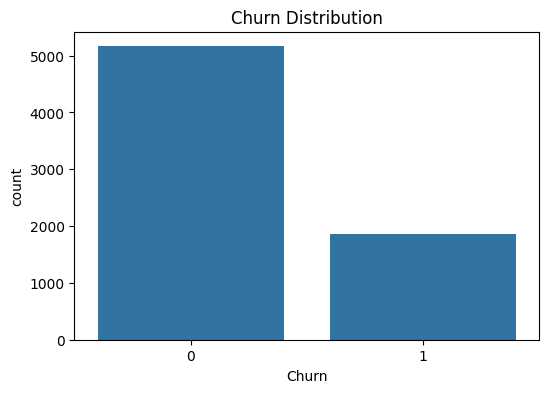

In [49]:
# 6. EDA Visualization
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

In [51]:
# 7. Feature Engineering
X = df.drop('Churn', axis=1)
y = df['Churn']

In [50]:
# 7. Feature Engineering
X = df.drop('Churn', axis=1)
y = df['Churn']

In [55]:
# 8. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    StandardScaler().fit_transform(X),
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [56]:
# 9. Model Training
model = RandomForestClassifier(
    n_estimators=150,
    max_depth=9,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=150,
                       random_state=42)

In [57]:
# 10. Model Evaluation
y_pred = model.predict(X_test)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))


Accuracy: 76.40%
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1033
           1       0.54      0.75      0.63       374

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407



ROC-AUC: 0.83


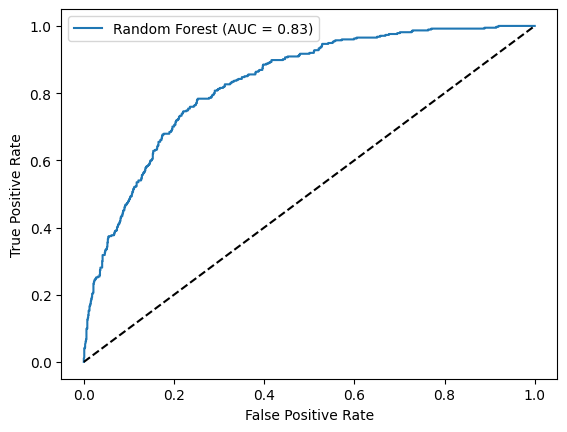

In [58]:
# 11. ROC Curve
y_proba = model.predict_proba(X_test)[:,1]
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


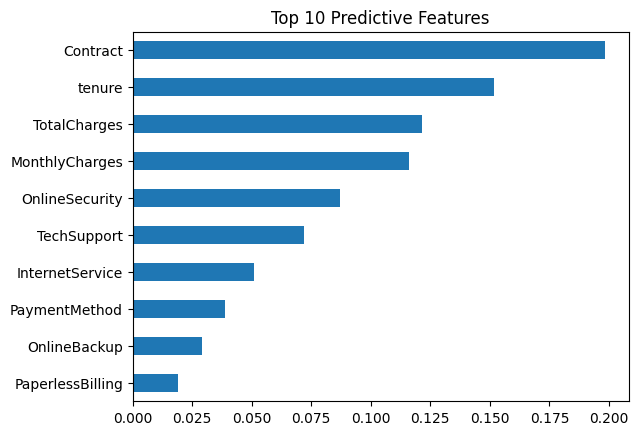

In [59]:
# 12. Feature Importance
pd.Series(model.feature_importances_, index=X.columns)\
  .sort_values().tail(10)\
  .plot(kind='barh', title='Top 10 Predictive Features')
plt.show()

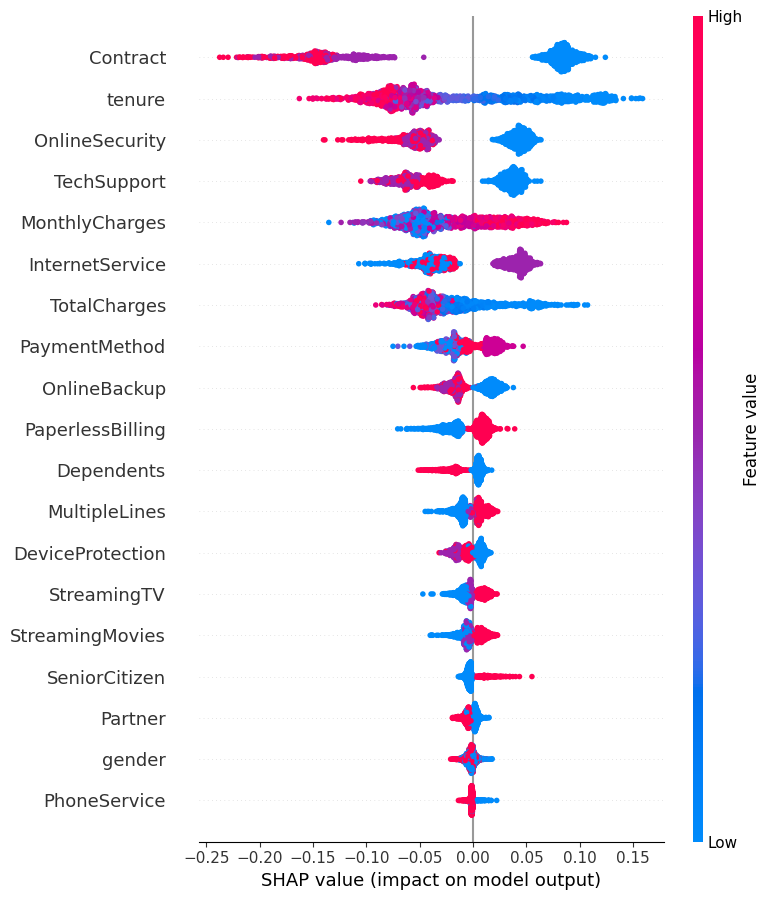

In [61]:
# 13. SHAP Explainability
X_test_df = pd.DataFrame(X_test, columns=X.columns)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_df)

# Handle SHAP output based on shape
if isinstance(shap_values, list):
    # Binary classification: [class0, class1]
    shap.summary_plot(shap_values[1], X_test_df, plot_type='dot')
elif len(shap_values.shape) == 3:
    # 3D array (n_samples, n_features, 2)
    shap.summary_plot(shap_values[:, :, 1], X_test_df, plot_type='dot')
else:
    # Fallback for other cases
    shap.summary_plot(shap_values, X_test_df, plot_type='dot')
